# Using LSTM to predict the Tokyo Stock Exchange variations

One of the first exercise we are proposed to do with Long Short Term Memory models is to try to predict the stock exchange variations.

When we look at the graphs produced by these models, it's quite impressive to see the Training and Test line hug the real price so close, but how good are these predictions?

Hypothesis:
* We only try to predict the next day, because more than that, any model just have no clue where things are going, and the accumulation of unknown just makes it even less reliable. So day traiding scenario only.
* Because values are normalized in order to train the model, the prediction will also be normalized, which means that it will not give a price. We could try to convert the value back to a real value, but is it really necessary? If the objective is just to guess which stock will go up, and how confident we are that it will go up, just a general indication (up/down) could be sufficient.
* Because different areas tend to react differently to the world situation, especially now taht we are during the Covid-19 Pandemic, I decided to concentrate on an area that I hope will be successful: Pharmaceuticals

With these hypothesis, I tried to train a model that would look at the past values, and try to guess which stock should be purchased tomorrow morning, because it should be going up during the day.

## Conclusion

See at the end.

## Spoilers

It's quite unreliable. I wouldn't use this to blindly chose my investments.

## Importing libraries

In [1]:
import matplotlib.pyplot as plt
# import seaborn
import json
from datetime import date
import datetime
import random
import time
from os import path
import pandas as pd
import numpy as np
from scipy.stats import beta
from math import sqrt

import requests

# from pandas_datareader import data as dr

from html.parser import HTMLParser
from html.entities import name2codepoint

# pip install opencv-python matplotlib numpy scipy keras scikit-learn tensorflow

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras

np.random.seed(42)

# pip install yfinance
import yfinance as yf

%matplotlib inline

# %load_ext autoreload
# %autoreload 2


Using TensorFlow backend.


# Load/Update of the list of symbols from Nikkei 225 site

This next cell checks if there is a nikkei225.json file in the current folder and loads it. If there isn't one, it will go recover the latest list on the official nikkei site. 

(Source of the Nikkei 225 companies: https://indexes.nikkei.co.jp/en/nkave/index/component?idx=nk225. There is a screw up on their site for Osaka Gas, and I am too lazy to fix it in the code. There is one company that doesn't display well, and it's that one.)

In [2]:
nfile = 'nikkei225.json'

class MyHTMLParser(HTMLParser):    
    def handle_starttag(self, tag, attrs):
        global dept, nikkei225, area, company, location
        
        dept += 1
        for attr in attrs:
            if attr[0] == 'class':
                if attr[1] == 'col-xs-11 col-sm-11' and dept == 8:
                    location = 0
                    company = {
                        'code': "",
                        'url': "",
                        'name': "",
                        'area': ""
                    }
                elif attr[1] == 'col-xs-3 col-sm-1_5' and dept == 8:
                    location = 1
            elif attr[0] == 'href' and location == 2:
                company['url'] = attr[1]
                location = 3

    def handle_endtag(self, tag):
        global dept
        dept -= 1

    def handle_data(self, data):
        global dept, nikkei225, area, company, location
        if location == 0 and dept == 8:
            print("Area:", data)
            company["area"] = data
            location = None
        elif location == 1 and dept == 8 and data not in ['Code', 'Company Name']:
            company['code'] = data + ".T"
            location = 2
        elif location == 3 and dept == 8:
            company['name'] = data
            nikkei225[company['code']] = dict(company)                

            
if path.exists(nfile):
    if (time.time() - path.getmtime(nfile) < (7 * 24 * 60 * 60)): # Update the list every week
        print('the current {} file is good enough'.format(nfile))
        with open(nfile, 'r') as infile:
            nikkei225 = json.load(infile)
    else:
        print('the current {} file is too old'.format(nfile))
        nikkei225 = {}
        
if len(nikkei225.keys()) == 0:
    nikkei225 = {}
    company = {}
    area = ""
    dept = 0
    location = None
    
    r = requests.get('https://indexes.nikkei.co.jp/en/nkave/index/component?idx=nk225')
    print('http get status', r.status_code, 'length', len(r.text))
    parser = MyHTMLParser()
    parser.feed(r.text)
    
    with open(nfile, 'w') as outfile:
        json.dump(nikkei225, outfile)

print('Number of symbols in the Nikkei 225 index: {}'.format(len(nikkei225.keys())))

the current nikkei225.json file is good enough
Number of symbols in the Nikkei 225 index: 225


# Download the current symbol values from the Yahoo Finance Site

In [20]:
today = datetime.date.today()
tomorrow = today + datetime.timedelta(days=1)
print('today', today.strftime("%Y-%m-%d"), 'tomorrow', tomorrow.strftime("%Y-%m-%d"))

indexes = ['^N225', '^SPX', 'DOW']

tickers = list(nikkei225.keys()) + indexes
start_date = '2018-01-01'
end_date = tomorrow

all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')

today 2020-05-29 tomorrow 2020-05-30


In [21]:
# Downloading the values from Yahoo Finance here
df_raw_nikkei225 = yf.download(tickers, start=start_date, end=end_date)

[*********************100%***********************]  228 of 228 completed


In [22]:
# A bit of cleanup...
df_clean_nikkei225 = df_raw_nikkei225.reindex(all_weekdays)
df_clean_nikkei225 = df_clean_nikkei225.fillna(method='ffill')

df_clean_nikkei225

Adj Close                                                      \
                1332.T       1333.T       1605.T       1721.T       1801.T   
2018-01-01  569.744080  3270.879639  1344.925293  3092.923340  5212.154297   
2018-01-02  569.744080  3270.879639  1344.925293  3092.923340  5212.154297   
2018-01-03  569.744080  3270.879639  1344.925293  3092.923340  5212.154297   
2018-01-04  570.711304  3285.310059  1391.219727  3178.179688  5323.644043   
2018-01-05  570.711304  3285.310059  1381.674561  3154.497314  5370.098145   
...                ...          ...          ...          ...          ...   
2020-05-25  488.000000  2213.000000   739.000000  2989.000000  3620.000000   
2020-05-26  499.000000  2279.000000   749.099976  2904.000000  3700.000000   
2020-05-27  504.000000  2336.000000   770.700012  3005.000000  3715.000000   
2020-05-28  510.000000  2349.000000   765.000000  2998.000000  3775.000000   
2020-05-29  510.000000  2349.000000   765.000000  2998.000000  3775.000000   

                                                                             \
                 1802.T       1803.T       1808.T       1812.T       1925.T   
2018-01-01  1269.765381  1109.852905  1591.134033  2022.888062  3972.852539   
2018-01-02  1269.765381  1109.852905  1591.134033  2022.888062  3972.852539   
2018-01-03  1269.765381  1109.852905  1591.134033  2022.888062  3972.852539   
2018-01-04  1294.899902  1133.689819  1622.938477  2069.541260  4092.212402   
2018-01-05  1299.554565  1134.643433  1646.564697  2067.675293  4145.465332   
...                 ...          ...          ...          ...          ...   
2020-05-25   954.000000   862.000000  1278.000000  1170.000000  2607.000000   
2020-05-26   996.000000   893.000000  1306.000000  1195.000000  2702.000000   
2020-05-27  1015.000000   910.000000  1309.000000  1233.000000  2655.000000   
2020-05-28  1014.000000   923.000000  1308.000000  1240.000000  2683.000000   
2020-05-29  1014.000000   923.000000  1308.000000  1240.000000  2683.000000   

            ...     Volume                                           \
            ...     9532.T    9602.T     9613.T    9735.T    9766.T   
2018-01-01  ...        0.0       0.0        0.0       0.0       0.0   
2018-01-02  ...        0.0       0.0        0.0       0.0       0.0   
2018-01-03  ...        0.0       0.0        0.0       0.0       0.0   
2018-01-04  ...  1646900.0  643400.0  4249800.0  800000.0  797600.0   
2018-01-05  ...  1524300.0  254900.0  3359400.0  685200.0  494200.0   
...         ...        ...       ...        ...       ...       ...   
2020-05-25  ...   579700.0  237600.0  3332200.0  284800.0  369300.0   
2020-05-26  ...   802200.0  393200.0  3907900.0  346900.0  590400.0   
2020-05-27  ...  1418200.0  395500.0  4849500.0  425800.0  854700.0   
2020-05-28  ...  1772200.0  417300.0  3604400.0  736600.0  941700.0   
2020-05-29  ...  1772200.0  417300.0  3604400.0  736600.0  941700.0   

                                                                      
               9983.T      9984.T        DOW     ^N225          ^SPX  
2018-01-01        0.0         0.0        NaN       NaN           NaN  
2018-01-02        0.0         0.0        NaN       NaN           NaN  
2018-01-03        0.0         0.0        NaN       NaN           NaN  
2018-01-04   997900.0  17888400.0        NaN  102200.0           NaN  
2018-01-05   731100.0  11306200.0        NaN  101900.0           NaN  
...               ...         ...        ...       ...           ...  
2020-05-25   853700.0  19463100.0  3040600.0   55100.0           NaN  
2020-05-26  1254200.0  25658500.0  6188600.0   87200.0           NaN  
2020-05-27  1186000.0  24286400.0  6889500.0  112000.0           NaN  
2020-05-28  1523200.0  28688000.0  5125556.0       0.0  3.140297e+09  
2020-05-29  1523200.0  28688000.0  5125556.0       0.0  3.140297e+09  

[630 rows x 1368 columns]

In [23]:
# keeping a dataframe with just the close values
df_close_nikkei225 = df_clean_nikkei225['Close']

# here I am adding few values, mainly rolling averages over 5,20 and 100 days, 
# then the ratio between the 5 and 20 days rolling average, then 20 and 100 days
# I am also adding value of the nikkei index to each entry.
for symbol in [x for x in nikkei225.keys()]:
    df_clean_nikkei225[('RollAvg5', symbol)] = df_close_nikkei225.loc[:, symbol].rolling(window=5).mean()
    df_clean_nikkei225[('RollAvg20', symbol)] = df_close_nikkei225.loc[:, symbol].rolling(window=20).mean()
    df_clean_nikkei225[('RollAvg100', symbol)] = df_close_nikkei225.loc[:, symbol].rolling(window=100).mean()
    for i in indexes:
        df_clean_nikkei225[(i, symbol)] = df_close_nikkei225.loc[:, i]
    
    df_clean_nikkei225[('ratio5-20', symbol)] = df_clean_nikkei225[('RollAvg5', symbol)] / df_clean_nikkei225[('RollAvg20', symbol)]
    df_clean_nikkei225[('ratio20-100', symbol)] = df_clean_nikkei225[('RollAvg20', symbol)] / df_clean_nikkei225[('RollAvg100', symbol)]
    
    
# keeping a dataframe with the relevant values used for our model
columns = ['Close', 'High', 'Low', 'Volume', 'RollAvg5', 'RollAvg20', 'RollAvg100', 'ratio5-20', 'ratio20-100'] + indexes
df_relev_nikkei225 = df_clean_nikkei225[columns]
df_relev_nikkei225.tail(-100)

Close                                                       \
           1332.T  1333.T       1605.T  1721.T  1801.T  1802.T  1803.T   
2018-05-21  570.0  4125.0  1378.500000  2921.0  6130.0  1161.0  1109.0   
2018-05-22  571.0  4065.0  1364.000000  2904.0  6140.0  1154.0  1106.0   
2018-05-23  562.0  4060.0  1302.500000  2891.0  6050.0  1142.0  1099.0   
2018-05-24  551.0  4110.0  1284.500000  2915.0  6060.0  1119.0  1087.0   
2018-05-25  547.0  4090.0  1248.500000  2929.0  6040.0  1136.0  1085.0   
...           ...     ...          ...     ...     ...     ...     ...   
2020-05-25  488.0  2213.0   739.000000  2989.0  3620.0   954.0   862.0   
2020-05-26  499.0  2279.0   749.099976  2904.0  3700.0   996.0   893.0   
2020-05-27  504.0  2336.0   770.700012  3005.0  3715.0  1015.0   910.0   
2020-05-28  510.0  2349.0   765.000000  2998.0  3775.0  1014.0   923.0   
2020-05-29  510.0  2349.0   765.000000  2998.0  3775.0  1014.0   923.0   

                                    ...        DOW                        \
            1808.T  1812.T  1925.T  ...     9101.T     9104.T     9107.T   
2018-05-21  1660.0  1822.0  4205.0  ...        NaN        NaN        NaN   
2018-05-22  1661.0  1834.0  4184.0  ...        NaN        NaN        NaN   
2018-05-23  1642.0  1842.0  4109.0  ...        NaN        NaN        NaN   
2018-05-24  1625.0  1818.0  4034.0  ...        NaN        NaN        NaN   
2018-05-25  1649.0  1828.0  4029.0  ...        NaN        NaN        NaN   
...            ...     ...     ...  ...        ...        ...        ...   
2020-05-25  1278.0  1170.0  2607.0  ...  36.119999  36.119999  36.119999   
2020-05-26  1306.0  1195.0  2702.0  ...  38.790001  38.790001  38.790001   
2020-05-27  1309.0  1233.0  2655.0  ...  39.820000  39.820000  39.820000   
2020-05-28  1308.0  1240.0  2683.0  ...  38.709999  38.709999  38.709999   
2020-05-29  1308.0  1240.0  2683.0  ...  38.709999  38.709999  38.709999   

                                                                              \
               9202.T     9301.T     9501.T     9502.T     9503.T     9531.T   
2018-05-21        NaN        NaN        NaN        NaN        NaN        NaN   
2018-05-22        NaN        NaN        NaN        NaN        NaN        NaN   
2018-05-23        NaN        NaN        NaN        NaN        NaN        NaN   
2018-05-24        NaN        NaN        NaN        NaN        NaN        NaN   
2018-05-25        NaN        NaN        NaN        NaN        NaN        NaN   
...               ...        ...        ...        ...        ...        ...   
2020-05-25  36.119999  36.119999  36.119999  36.119999  36.119999  36.119999   
2020-05-26  38.790001  38.790001  38.790001  38.790001  38.790001  38.790001   
2020-05-27  39.820000  39.820000  39.820000  39.820000  39.820000  39.820000   
2020-05-28  38.709999  38.709999  38.709999  38.709999  38.709999  38.709999   
2020-05-29  38.709999  38.709999  38.709999  38.709999  38.709999  38.709999   

                       
               9532.T  
2018-05-21        NaN  
2018-05-22        NaN  
2018-05-23        NaN  
2018-05-24        NaN  
2018-05-25        NaN  
...               ...  
2020-05-25  36.119999  
2020-05-26  38.790001  
2020-05-27  39.820000  
2020-05-28  38.709999  
2020-05-29  38.709999  

[530 rows x 2712 columns]

## Graphing a single symbol with rolling averages (5, 20, 50 days)

4755.T


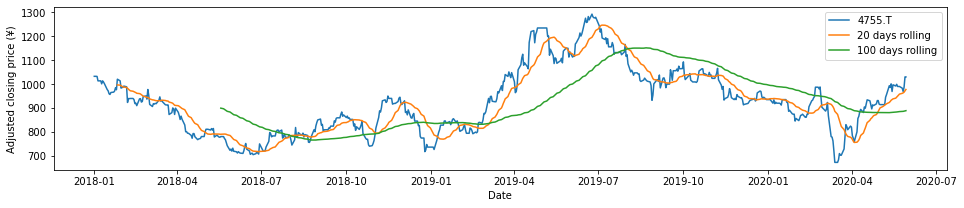

In [24]:
## This cell is just for testing. it will graph a symbol after recalculating rolling averages
# The graph_symbol function is also used later on.

def graph_symbol(symbol, df):
    print(symbol)
    # Get the timeseries. This now returns a Pandas Series object indexed by date.

    wtv = df.loc[:, symbol]

    roll_20_days = wtv.rolling(window=20).mean()
    roll_100_days = wtv.rolling(window=100).mean()

    # Plot everything
    fig, ax = plt.subplots(figsize=(16,3))

    ax.plot(wtv.index, wtv, label=symbol)
    ax.plot(roll_20_days.index, roll_20_days, label='20 days rolling')
    ax.plot(roll_100_days.index, roll_100_days, label='100 days rolling')

    ax.set_xlabel('Date')
    ax.set_ylabel('Adjusted closing price (¥)')
    ax.legend()
    plt.show()

graph_symbol('4755.T', df_close_nikkei225)

## Defining the model

The next cell defines the function that will return a LSTN RNN.

In [25]:
# LSTM Related functions

def build_part1_RNN(window_size, n_features = 1, nodes = 5, dropout=0.2):
    model = Sequential()
    model.add(LSTM(nodes, activation='tanh', input_shape=(window_size, n_features), dropout=dropout))
    model.add(Dense(1))
    
    # build model using keras documentation recommended optimizer initialization
    optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

    # compile the model
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    # model.compile(loss='mae', optimizer='adam')
        
    return model

## Preparing the data to train the model

The `window_transform_3d_series` function returns the series days (X) and the value that need to be predicted (y)

In [26]:
# convert series to supervised learning
def window_transform_3D_series(df_X, df_y, window_size):
    # containers for input/output pairs
    X = []
    y = []
    
    for ii in range(len(df_X) - (window_size)):
        X.append(list(df_X.iloc[ii:ii+window_size].values))
        y.append(df_y.iloc[ii+window_size])

    # reshape each
    X = np.asarray(X)
    X.shape = (np.shape(X)[0:3])
    y = np.asarray(y)
    y.shape = (len(y),1)
    

    return X, y

def mean_beta(a, b):
    mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')
    return mean

if False: #testing function, just to confirm that the values are properly returned by window_transform_3D_series
    window_size = 8
    features = ['Close']
    objective='Close'
    n_features = len(features)

    for symbol in list(df_close_nikkei225.keys())[:1]:
        print(symbol)
        df_X = df_relev_nikkei225.loc[:, [(x, symbol) for x in features]]
        df_y = df_relev_nikkei225.loc[:, (objective, symbol)]

        df_X_scaled=((df_X-df_X.mean())/df_X.std())
        df_y_scaled=((df_y-df_y.mean())/df_y.std())

        X,y = window_transform_3D_series(df_X_scaled.fillna(0), df_y_scaled.fillna(0), window_size)

## Initializing the model

In [27]:
def training(nikkei225, df_relev_nikkei225, areas, model, window_size, features, objective, epochs, batch_size, verbose=True):
    n_features = len(features)
       
    if len(areas) == 0:
        array = [x for x in nikkei225.keys()]
    else:
        array = [x for x in nikkei225.keys() if nikkei225[x]['area'] in areas]
        
    np.random.shuffle(array)
    
    for s in range(len(array)):
        symbol = array[s]
        df_X = df_relev_nikkei225.loc[:, [(x, symbol) for x in features]]
        df_y = df_relev_nikkei225.loc[:, (objective, symbol)]

        df_X_scaled=(df_X-df_X.mean())/df_X.std()
        df_y_scaled=(df_y-df_y.mean())/df_y.std()

        X,y = window_transform_3D_series(df_X_scaled.fillna(0), df_y_scaled.fillna(0), window_size)

        train_test_split = int(np.ceil(4*len(y)/float(5)))   # set the split point

        X_train = X[:train_test_split,:]
        y_train = y[:train_test_split]

        # keep the last chunk for testing
        X_test = X[train_test_split:,:]
        y_test = y[train_test_split:]

        # NOTE: to use keras's RNN LSTM module our input must be reshaped to [samples, window size, stepsize] 
        X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, n_features)))
        X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, n_features)))

        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0, shuffle=True)

        # generate predictions for training
        train_predict = model.predict(X_train)
        test_predict = model.predict(X_test)

        # print out training and testing errors
        training_error = model.evaluate(X_train, y_train, verbose=0)
        testing_error = model.evaluate(X_test, y_test, verbose=0)
        if verbose:
            print('* {} {} training error = {:0.3f} ({}), testing error: {:0.3f} ({})'.format(
                symbol, nikkei225[symbol]['name'], 
                training_error, training_error < error_objective, 
                testing_error, testing_error < error_objective
            ))


    if verbose:
        # plot history
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show()
        
        plt.figure(figsize=[20,15])
        plt.grid(True)
        plt.plot(df_X_scaled[objective].reset_index(drop=True),color = 'k')


        # plot training set prediction
        split_pt = train_test_split + window_size 
        plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

        # plot testing set prediction
        plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'r')

        # pretty up graph
        plt.xlabel('day')
        plt.ylabel('(normalized) price of {} stock'.format(symbol))
        plt.legend(['original series','training fit','testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()
    
    return model
        


# Training the model with the Nikkei225 values

Here we are defining the parameters of the model, then we initialize it and start the training.

> Note: The training function is hardcoded to focus only on pharmaceutical companies

* 4523.T EISAI CO., LTD. training error = 0.042 (False), testing error: 0.105 (False)
* 4502.T TAKEDA PHARMACEUTICAL CO., LTD. training error = 0.021 (False), testing error: 0.128 (False)
* 4507.T SHIONOGI & CO., LTD. training error = 0.037 (False), testing error: 0.340 (False)
* 4568.T DAIICHI SANKYO CO., LTD. training error = 0.021 (False), testing error: 0.165 (False)
* 4151.T KYOWA KIRIN CO., LTD. training error = 0.046 (False), testing error: 0.612 (False)
* 4578.T OTSUKA HOLDINGS CO., LTD. training error = 0.052 (False), testing error: 0.234 (False)
* 4519.T CHUGAI PHARMACEUTICAL CO., LTD. training error = 0.017 (True), testing error: 0.586 (False)
* 4503.T ASTELLAS PHARMA INC. training error = 0.051 (False), testing error: 0.101 (False)
* 4506.T SUMITOMO DAINIPPON PHARMA CO., LTD. training error = 0.054 (False), testing error: 0.115 (False)


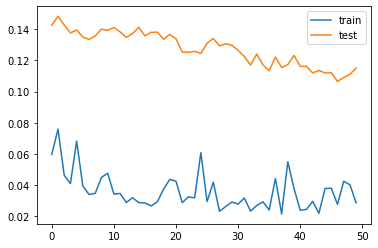

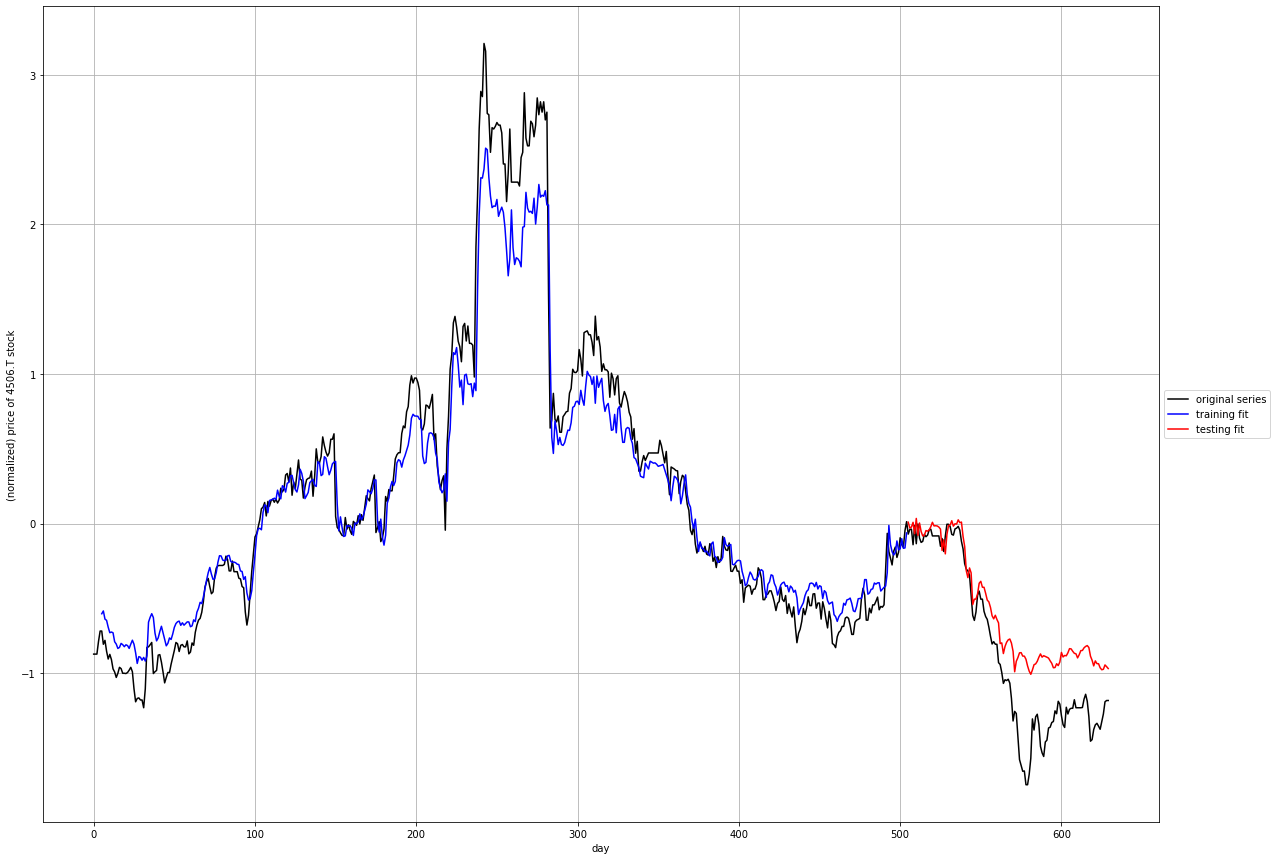

In [28]:
window_size = 5
features = [
    'Close',
    'Low',
    'High',
    #'RollAvg5', 
    #'RollAvg100',
    'ratio5-20',
    #'ratio20-100',
    'Volume',
] + indexes

n_features = len(features)

objective='Close'
areas = ['Pharmaceuticals']#, 'Services']

error_objective = 0.02

epochs = 50
batch_size = 50
nodes = len(features)
dropout = 0.2

model = build_part1_RNN(window_size, n_features, nodes, dropout)

model = training(nikkei225, df_relev_nikkei225, areas, model, window_size, features, objective, epochs, batch_size, True)

Impressive! It kind of follow the real values, like for all the LSTM examples! ^_^

# Applying to predict the future

Now what? What can we do with this?

Let's say that we still take all the pharmaceutical companies listed in the Nikkei225, can we guess which ones will go up or down? How successful are the predictions? Can we trust them to help taking a decision about the next day's movements? 

This is what the following cell is doing. 
* It's going through all companies in the pharmaceutical area and rerun the training and testing values against the model. 
* While doing so, it will try to guess if the next day will go up or down, only on the test values, unused during the training.
* and if it goes up, does it goes up significantly enough in order to make profit? (+0.05 of the previously normalized value, this is arbitrary)
* For the one that does not qualify, we just forget about them. They can both be missed opportunities, or cases where value would really had declined.
* We then confirm if we did a good call to `buy` shares.
* At the last step, the code will display which symbol he thinks should be purchased, how many times the model was right (a)/wrong (b), and how much capital we would have if we had followed all the predictions, just for fun.

In [29]:
def strategy_predict_higher(predicted, previous_prediction):
    decision = False
    difference = predicted - previous_prediction
            
    if difference <= 0:
        guess = 'Down'.format(predicted)
    else:
        guess = 'Up'.format(predicted)
        
        if difference > predicted:
            decision = True
                    
    return decision, guess

def strategy_random(predicted, previous_prediction):   
    difference = predicted - previous_prediction
    
    if difference < 0:
        guess = 'Down'.format(predicted)
    else:
        guess = 'Up'.format(predicted)

    decision = random.randint(0,1)
    
    return decision, guess

In [30]:
def best_options(nikkei225, df_relev_nikkei225, areas, model, window_size, features, objective, strategy, verbose=False):
    
    df_future = pd.DataFrame(columns = ['date', 'symbol', 'name', 'area', 'close', 'close_normalized', 'prediction', 'percent', 'direction', 'buy', 'a', 'b', 'mean_beta', 'capital'])
    n_features = len(features)
    aa = 1
    bb = 1
    
    if len(areas) == 0:
        array = [x for x in nikkei225.keys()]
    else:
        array = [x for x in nikkei225.keys() if nikkei225[x]['area'] in areas]
        
    np.random.shuffle(array)
    
    for s in range(len(array)):
        symbol = array[s]
        
        df_X = df_relev_nikkei225.loc[:, [(x, symbol) for x in features]]
        df_y = df_relev_nikkei225.loc[:, (objective, symbol)]

        df_X_scaled=(df_X-df_X.mean())/df_X.std()
        df_y_scaled=(df_y-df_y.mean())/df_y.std()

        X,y = window_transform_3D_series(df_X_scaled.fillna(0), df_y_scaled.fillna(0), window_size)

        train_test_split = int(np.ceil(4*len(y)/float(5)))   # set the split point (80%)

        # keep the last chunk for testing
        X_test = X[train_test_split:,:]
        y_test = y[train_test_split:]

        # NOTE: to use keras's RNN LSTM module our input must be reshaped to [samples, window size, n_features] 
        X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, n_features)))

        # generate predictions for training
        test_predict = model.predict(X_test)

        df_X_scaled_reindexed = df_X_scaled.reset_index()
        df_y_scaled_reindexed = df_y_scaled.reset_index()
        
        df_y_reindexed = df_y.reset_index()

        a = 1
        b = 1
        capital = 0
    
        for t in range(1, len(y_test-1)):
            
            scaled_sr = df_y_scaled_reindexed.iloc[train_test_split + t + window_size-1][['index', objective]]
            raw_sr = df_y_reindexed.iloc[train_test_split + t + window_size-1][['index', objective]]
            raw_tomorrow_sr = df_y_reindexed.iloc[train_test_split + t + window_size][['index', objective]]
            
            rday = str(raw_sr['index'].values[0]).split('T')[0]
            rtomorrow = str(raw_tomorrow_sr['index'].values[0]).split('T')[0]
            
            scaled_close = scaled_sr[(objective, symbol)]
            raw_close = raw_sr[(objective, symbol)]

            predicted = test_predict[t][0]
            previous_prediction = test_predict[t-1][0]
            
            
            if strategy == 'higher':
                decision, guess = strategy_predict_higher(predicted, previous_prediction)
            elif strategy == 'random':
                decision, guess = strategy_random(predicted, previous_prediction)
            else: # if the strategy is undefined, we don't buy anything
                decision = False
                guess = 'Undefined'
            
            
            if len(y_test) > t+1:
                scaled_next = y_test[t]
                raw_next = raw_tomorrow_sr[(objective, symbol)]

                profit =  raw_next - raw_close

                if decision: # We decide to buy
                    
                    capital += profit # Adjust how much capital was gained/lost
                    
                    if profit > 0: # Keep track of how many time we were successful...
                        a+=1 # local for the symbol
                        aa+=1 # global for all symbols
                    if profit <= 0: # or not successful
                        b+=1
                        bb+=1

                    if False:
                        if profit > 0:
                            print(scaled_close, raw_close, predicted, guess, decision, profit)
                            
                else: # When we decide not to buy...
                    if profit < 0: # and we were right...
                        a+=1
                        aa+=1
                    if profit > 0 and False: # lost opportunity but I think we shouldn't be punished for it
                        b+=1
                        bb+=1
                    
                    
            else: # Exit condition: We can't confirm the prediction with the value of the next day
                item = {
                    'symbol': symbol,
                    'name': nikkei225[symbol]['name'],
                    'area': nikkei225[symbol]['area'],
                    'date': rday,
                    'close': raw_close,
                    'close_normalized': scaled_close, 
                    'prediction': predicted,
                    'percent': previous_prediction/predicted,
                    'direction': guess, 
                    'buy': decision, 
                    'a': a, 
                    'b': b, 
                    'mean_beta': mean_beta(a,b),
                    'capital': capital
                }

                df_future = df_future.append(item, ignore_index=True)
                if item['buy']:
                    print("{} {} {} (buy: {}) mean_beta: {:0.3f}, capital: {}".format(item['symbol'], item['name'], item['area'], item['buy'], item['mean_beta'], capital))


    return mean_beta(aa,bb), df_future

In [31]:
strategy = 'higher'

mbeta, df_future = best_options(nikkei225, df_relev_nikkei225, areas, model, window_size, features, objective, strategy, True)
print('\nmean_beta: {:0.4f}'.format(mbeta))

4578.T OTSUKA HOLDINGS CO., LTD. Pharmaceuticals (buy: True) mean_beta: 0.760, capital: 747.0
4507.T SHIONOGI & CO., LTD. Pharmaceuticals (buy: True) mean_beta: 0.831, capital: 639.0
4502.T TAKEDA PHARMACEUTICAL CO., LTD. Pharmaceuticals (buy: True) mean_beta: 0.689, capital: 726.0

mean_beta: 0.8230


That last mean_beta value is an important indicator. It means that the model and conditions was successful ~80.8% of the time with the current model and parameters.

It is important to take into consideration how "successes" and "failures" is defined:
* if an increase is predicted, we decide to buy, and there is a profit (>0) observed the next day: `success`
* if an increase is predicted, we decide to buy, and there is a loss (<=0) observed the next day: `failure`
* if a loss is predicted, we decide not to buy, and there is a loss (<=0) observed the next day: `success`
* if a loss is predicted, we decide not to buy, and there is a profit (>0) the next day: `neither success/failure`. just a lost opportunity.

This last situation does have an impact on the success rate.

## According to our model, which stock is expected to rise tomorrow?

In [32]:
budget_limit = 3000 # maximum price willing to pay per share

df_future[(df_future['buy'] == True) & (df_future['close'] < budget_limit)].sort_values(['mean_beta'], ascending=False)

,date,symbol,name,area,close,close_normalized,prediction,percent,direction,buy,a,b,mean_beta,capital


In this case, the model is telling us that we should not buy any share because it believes that one will be profitable enough.

In [33]:
# this cell graphes all the shares identified as potentials by the model.
for i, r in df_future[(df_future['buy'] == True) & (df_future['close'] < budget_limit)].sort_values(['mean_beta'], ascending=False).iterrows():
    graph_symbol(r['symbol'], df_close_nikkei225)

## How about the other stocks, what should happen to them?

Ok, the model is telling us that we should not buy anything, but does this mean that no share will be going up? Here, because I did set a maximum budget per share to 2000¥, anything that is more expensive will not be displayed.

The following cell is displaying all the shares that are predicted to go up, regardless of the budget, or the expectations of profits.

In [34]:
df_future[df_future['direction'].isin(['Up', 'Down'])].sort_values(['mean_beta'], ascending=False).head(20)

,date,symbol,name,area,close,close_normalized,prediction,percent,direction,buy,a,b,mean_beta,capital
1,2020-05-28,4568.T,"DAIICHI SANKYO CO., LTD.",Pharmaceuticals,9293.0,2.604140,1.947017,1.005030,Down,False,54,1,0.9818181818181818,0.0
7,2020-05-28,4519.T,"CHUGAI PHARMACEUTICAL CO., LTD.",Pharmaceuticals,15025.0,3.159840,2.568965,0.965596,Up,False,54,1,0.9818181818181818,0.0
3,2020-05-28,4151.T,"KYOWA KIRIN CO., LTD.",Pharmaceuticals,2885.0,3.005974,2.136147,0.955040,Up,False,54,2,0.9642857142857143,214.0
8,2020-05-28,4503.T,ASTELLAS PHARMA INC.,Pharmaceuticals,1874.5,1.312350,0.995387,0.642118,Up,False,53,7,0.8833333333333333,120.5
4,2020-05-28,4507.T,"SHIONOGI & CO., LTD.",Pharmaceuticals,6076.0,-0.226630,-0.195821,1.583402,Up,True,64,13,0.8311688311688312,639.0
6,2020-05-28,4523.T,"EISAI CO., LTD.",Pharmaceuticals,8050.0,0.192265,0.188977,0.517673,Up,False,57,12,0.8260869565217391,1616.0
2,2020-05-28,4578.T,"OTSUKA HOLDINGS CO., LTD.",Pharmaceuticals,4669.0,-0.057799,-0.227478,2.160626,Up,True,57,18,0.76,747.0
5,2020-05-28,4502.T,"TAKEDA PHARMACEUTICAL CO., LTD.",Pharmaceuticals,4163.0,-0.327061,-0.256205,1.042639,Up,True,62,28,0.6888888888888889,726.0
0,2020-05-28,4506.T,"SUMITOMO DAINIPPON PHARMA CO., LTD.",Pharmaceuticals,1495.0,-1.182916,-0.969175,0.987072,Down,False,55,34,0.6179775280898876,-275.0


### Descriptions of the columns

* date: current date
* symbol: symbol on the Tokyo Stock Exchange (nikkei)
* name: official company name
* area: The nikkei is grouped in multiple areas
* close: closing price
* close_normalized: all values are normalized, this is the value once normalized
* prediction: the model predict that the next close_normalized value should be of x (also normalized)
* direction: here we are comparing against the last prediction value, because often the close value and the prediction value aren't exactly the same
* buy: should we buy or not?
* a: this to calculate the mean beta distribution: a == successfully predicted the next day during training
* b: this to calculate the mean beta distribution: b == failed to predict the next day during training
* mean_beta: mean beta distribution, what is the percentage of success of the model at predicting the model for that symbol
* capital: this is just to toy around. starting with a capital of 0 on 2019-01-01, if we buy when the model tells to buy, how much yens would we have a the end?

## The trading day is over. How much money did we make?

So the night before the model gave us a bunch of shares to select from. Let's say that I bought 100 of each. Now that the day of training is over (passed 15:00 JST), how much money did I make?

In [18]:
now = datetime.date.today()
yesterday = now - datetime.timedelta(days=5)
tomorrow = now + datetime.timedelta(days=1)
print('yesterday', yesterday.strftime("%Y-%m-%d"), 'now', now.strftime("%Y-%m-%d"), 'tomorrow', tomorrow.strftime("%Y-%m-%d"))

focus_tickers = list(df_future[df_future['direction'].isin(['Up'])]['symbol'].unique())
start_date = yesterday.strftime("%Y-%m-%d")
end_date = tomorrow.strftime("%Y-%m-%d")
print(focus_tickers)

# Downloading the values from Yahoo Finance here
df_raw_focus_nikkei225 = yf.download(focus_tickers, start=start_date, end=end_date)

# A bit of cleanup...
all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')
df_clean_focus_nikkei225 = df_raw_focus_nikkei225.reindex(all_weekdays)
df_clean_focus_nikkei225 = df_clean_focus_nikkei225.fillna(method='ffill')

# keeping a dataframe with just the close values
df_clean_focus_nikkei225['Close']

yesterday 2020-05-23 now 2020-05-28 tomorrow 2020-05-29
['4503.T', '4506.T', '4151.T', '4502.T', '4578.T', '4519.T', '4523.T', '4568.T', '4507.T']
[*********************100%***********************]  9 of 9 completed


,4151.T,4502.T,4503.T,4506.T,4507.T,4519.T,4523.T,4568.T,4578.T
2020-05-25,2774.0,4118.0,1746.0,1414.0,5843.0,14450.0,7580.0,8863.0,4269.0
2020-05-26,2803.0,4195.0,1721.0,1443.0,5891.0,14885.0,7701.0,9351.0,4308.0
2020-05-27,2839.0,4138.0,1818.0,1490.0,6045.0,14980.0,7915.0,9207.0,4390.0
2020-05-28,2885.0,4163.0,1874.5,1495.0,6076.0,15025.0,8050.0,9293.0,4669.0
2020-05-29,2885.0,4163.0,1874.5,1495.0,6076.0,15025.0,8050.0,9293.0,4669.0


In [19]:
series_capital = (df_clean_focus_nikkei225['Close'].loc[today] - df_clean_focus_nikkei225['Close'].loc[yesterday]) * 100
print('Symbols with profits: {}. with losses: {}. Capital Gain/loss: {:0.0f}¥'.format(series_capital.where(series_capital>0).count(), series_capital.where(series_capital<=0).count(), series_capital.sum()))

KeyError: datetime.date(2020, 5, 23)

### if we look only at the symbols that were in budget:

In [ ]:
boughts = df_future[(df_future['buy'] == True) & (df_future['close'] < budget_limit)]['symbol'].unique()
print(boughts)
series_capital = (df_clean_focus_nikkei225['Close'].loc[today, boughts] - df_clean_focus_nikkei225['Close'].loc[yesterday, boughts]) * 100
print('Symbols with profits: {}. with losses: {}. Capital Gain/loss: {:0.0f}¥'.format(series_capital.where(series_capital>0).count(), series_capital.where(series_capital<=0).count(), series_capital.sum()))

### How performant is this prediction? 

Actually, I am quite surprised by this outcome. It must have been an exceptional day on the stock market, because success/fail tend to be close to the average. A success rate of 100% is really unlikely.

### How would a random strategy compete against this heavy model?

In [ ]:
strategy = 'random'

mbeta, df_future = best_options(nikkei225, df_relev_nikkei225, areas, model, window_size, features, objective, strategy, True)
print('mean_beta: ', mbeta)

Following the same conditions, a random selection would give us a success rate of 62%. A Random selection seems quite be quite comparable to our heavy LSTM model!

### How about if we don't buy anything?

In [ ]:
strategy = 'buy nothing!'

mbeta, df_future = best_options(nikkei225, df_relev_nikkei225, areas, model, window_size, features, objective, strategy, True)
print('mean_beta: ', mbeta)

We can't be wrong if we don't lose money... since we consider a missed opportunity just as good as not losing our investment.

# Conclusion

The predictions from the LSTM RNN seems to be following the reality, but if we try to use these predictions to take purchasing decisions, the results should be close to a coin toss.

What is scary is that a random selection manage to get a 62% success rate.

Can we use this in real life? I didn't. Not sure I will, especially not blindly.

# Optimization section

This section is mainly to try multiple parameters over and over, attempting to find the best parameters for the model.

It is currently set not to run.

In [ ]:
%%time 

def init_optimization(nikkei225, df_relev_nikkei225, areas, features, objective, strategy):
    df_mean_beta = pd.DataFrame(columns=['mean', 'window_size', 'epochs', 'features', 'nodes', 'dropout'])
    
    window_size_range = [3, 6]
    epochs_range = [30, 60]
    nodes_range = [5, 30]
    batch_size_range = [40, 75]
    dropout_range = [0.0, 0.2]
    n_features = len(features)
    
    max_tests = 10
    for r in range(max_tests):
        window_size = random.randint(window_size_range[0], window_size_range[1])
        epochs = np.random.randint(low=epochs_range[0], high=epochs_range[1])
        nodes = np.random.randint(low=nodes_range[0], high=nodes_range[1])
        dropout = np.random.uniform(low=dropout_range[0], high=dropout_range[1])
        batch_size = np.random.randint(low=batch_size_range[0], high=batch_size_range[1])

        print(r, window_size, epochs, features, nodes, dropout)
        
        model = build_part1_RNN(window_size, n_features, nodes, dropout)
        model = training(nikkei225, df_relev_nikkei225, areas, model, window_size, features, objective, epochs, batch_size, False)
        
        mbeta, df_future = best_options(nikkei225, df_relev_nikkei225, areas, model, window_size, features, objective, strategy, False)
        
        run = {
            'mean': mbeta,
            'window_size': window_size,
            'epochs': epochs,
            'features': ",".join(features),
            'nodes': nodes,
            'batch_size': batch_size,
            'dropout': dropout
        }
        print(run)
        
        df_mean_beta = df_mean_beta.append(run, ignore_index=True)
    return df_mean_beta
    

if True:
    areas = ['Pharmaceuticals']#, 'Foods', 'Services']
    
    features = [
        'Close',
        'Low',
        'High',
        #'RollAvg5', 
        #'RollAvg100',
        'ratio5-20',
        'ratio20-100',
        'Volume',
    ] + indexes
    
    objective = 'Close'
    strategy = 'higher'
    df_mean_beta = init_optimization(nikkei225, df_relev_nikkei225, areas, features, objective, strategy)
    
    

In [ ]:
df_mean_beta.sort_values(by='mean', ascending=False)

```
Area: Pharmaceuticals
Area: Electric Machinery
Area: Automobiles & Auto parts
Area: Precision Instruments
Area: Communications
Area: Banking
Area: Other Financial Services
Area: Securities
Area: Insurance
Area: Fishery
Area: Foods
Area: Retail
Area: Services
Area: Mining
Area: Textiles & Apparel
Area: Pulp & Paper
Area: Chemicals
Area: Petroleum
Area: Rubber
Area: Glass & Ceramics
Area: Steel
Area: Nonferrous Metals
Area: Trading Companies
Area: Construction
Area: Machinery
Area: Shipbuilding
Area: Other Manufacturing
Area: Real Estate
Area: Railway & Bus
Area: Land Transport
Area: Marine Transport
Area: Air Transport
Area: Warehousing
Area: Electric Power
Area: Gas
```